# Routing-based sanity check at dose = 0

This notebook visualizes the results of **Exp 8** and connects them to:

- the **PIER heatmap** (Exp 6), and  
- the **raw disagreement curves** (Exp 7).

Our goal is to answer the following question:

> At dose θ = 0 (no masking), PIER reports that ALBERT (and DistilBERT)
> are harder to approximate by the rest of the ecosystem than BERT, RoBERTa,
> or XLNet. However, simple disagreement curves do not clearly show this.
> Is PIER detecting a real structural difference, or is it an artifact?

Exp 8 implements a routing-based sanity check:

- For each target model \(t\) at θ = 0, we take the other models as peers \(\mathcal P_t\).
- We compute:
  - global disagreement \(D_t\),
  - the best single-peer approximation,
  - and the performance of an oracle router that, for each input, picks
    the peer with the closest prediction to the target.

If PIER is meaningful, models with large PIER at θ = 0 should also be
harder to approximate even for this oracle router baseline.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (4.0, 3.0)
plt.rcParams["figure.dpi"] = 150
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.3
plt.rcParams["font.size"] = 9
plt.rcParams["legend.frameon"] = False


In [2]:
tables_dir = os.path.join("..", "results", "tables")

exp6_path = os.path.join(tables_dir, "exp6_bert_multicontext_pier.csv")
exp7_path = os.path.join(tables_dir, "exp7_bert_context_disagreement.csv")
exp8_path = os.path.join(tables_dir, "exp8_routing_sanity_dose0.csv")

exp6_df = pd.read_csv(exp6_path)
exp7_df = pd.read_csv(exp7_path)
exp8_df = pd.read_csv(exp8_path)

exp6_df.head(), exp7_df.head(), exp8_df.head()


(  ContextType    ContextLabel TargetModel  Dose  MeanPIER   StdPIER  \
 0      length  len_long_(>15)        BERT   0.0  0.055089  0.159889   
 1      length  len_long_(>15)        BERT   0.1  0.067756  0.170627   
 2      length  len_long_(>15)        BERT   0.2  0.093854  0.190586   
 3      length  len_long_(>15)        BERT   0.3  0.128874  0.148331   
 4      length  len_long_(>15)        BERT   0.4  0.144561  0.179890   
 
    NumEvalPoints  NumFitPoints  ContextRawSize  
 0            100          1000             561  
 1            100          1000             561  
 2            100          1000             561  
 3            100          1000             561  
 4            100          1000             561  ,
   ContextType    ContextLabel TargetModel  Dose  MeanDisagreement  \
 0      length  len_long_(>15)        BERT   0.0          0.156301   
 1      length  len_long_(>15)        BERT   0.1          0.164920   
 2      length  len_long_(>15)        BERT   0.2       

In [3]:
def compute_pier_at_dose_zero(exp6_df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute global mean PIER per model at the lowest dose (theta = 0.0),
    averaging over all contexts.
    """
    # Find the minimum dose present in the Exp 6 table (should be 0.0)
    dose_min = float(exp6_df["Dose"].min())

    sub = exp6_df[exp6_df["Dose"] == dose_min].copy()
    pier_global = (
        sub.groupby("TargetModel")["MeanPIER"]
        .mean()
        .reset_index()
        .rename(columns={"MeanPIER": "PIER_Dose0"})
    )
    pier_global["DoseMin_Exp6"] = dose_min
    return pier_global


def compute_global_disagreement_at_dose_zero(exp7_df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute D_t at theta = 0.0, aggregating over contexts:

        D_t = weighted mean_c MeanDisagreement(c, theta=0)
    """
    dose_min = float(exp7_df["Dose"].min())
    sub = exp7_df[np.isclose(exp7_df["Dose"], dose_min)].copy()

    rows = []
    for model, df_m in sub.groupby("TargetModel"):
        weights = df_m["NumPoints"].values.astype(float)
        vals = df_m["MeanDisagreement"].values.astype(float)
        if weights.sum() <= 0:
            continue
        global_D = float(np.average(vals, weights=weights))
        rows.append(
            {
                "TargetModel": model,
                "Disagreement_Dose0": global_D,
                "DoseMin_Exp7": dose_min,
            }
        )
    return pd.DataFrame(rows)


pier_d0 = compute_pier_at_dose_zero(exp6_df)
disc_d0 = compute_global_disagreement_at_dose_zero(exp7_df)

pier_d0, disc_d0


(  TargetModel  PIER_Dose0  DoseMin_Exp6
 0      ALBERT    0.238954           0.0
 1        BERT    0.059811           0.0
 2  DistilBERT    0.409718           0.0
 3     RoBERTa    0.044835           0.0
 4       XLNet    0.073912           0.0,
   TargetModel  Disagreement_Dose0  DoseMin_Exp7
 0      ALBERT            0.163381           0.0
 1        BERT            0.159663           0.0
 2  DistilBERT            0.435186           0.0
 3     RoBERTa            0.153400           0.0
 4       XLNet            0.152859           0.0)

In [4]:
# In Exp 8, TargetModel uses the short names (BERT, DistilBERT, ...)
routing_df = exp8_df.copy()

# Merge PIER and Disagreement at dose 0
summary = (
    routing_df
    .merge(pier_d0, on="TargetModel", how="left")
    .merge(disc_d0, on="TargetModel", how="left")
)

# Reorder columns for readability
summary = summary[
    [
        "TargetModel",
        "GlobalDisagreement_D",
        "Disagreement_Dose0",
        "MAE_SinglePeer",
        "BestPeerName",
        "MAE_OracleRouter",
        "PIER_Dose0",
        "NumSamples",
    ]
]

summary = summary[summary.TargetModel != "DistilBERT"]  # Exclude DistilBERT for clarity


### Summary table at dose = 0

Each row is a target model \(t\).

- **GlobalDisagreement_D**  
  The raw global disagreement \(D_t\) used in Exp 7 at dose θ = 0:
  average absolute difference between the target and all peers.

- **Disagreement_Dose0**  
  The same quantity recomputed from Exp 7 by aggregating over contexts.
  This should closely match GlobalDisagreement_D.

- **MAE_SinglePeer**  
  The best possible mean absolute error when we always route to a *single* peer:
  \(\min_j \mathbb{E}_x |Y_t(x) - Y_j(x)|\).

- **BestPeerName**  
  The peer \(j\) that achieves MAE_SinglePeer.

- **MAE_OracleRouter**  
  The mean absolute error of the **oracle router**:
  for each input \(x\), we choose the peer with the closest prediction to the target:
  \(\mathbb{E}_x \min_j |Y_t(x) - Y_j(x)|\).
  Any realistic hard-routing strategy can only do worse than this lower bound.

- **PIER_Dose0**  
  The global PIER score at θ = 0 from Exp 6, averaged over contexts.

We now visualize these quantities to compare the rankings induced by
raw disagreement, the routing baselines, and PIER.


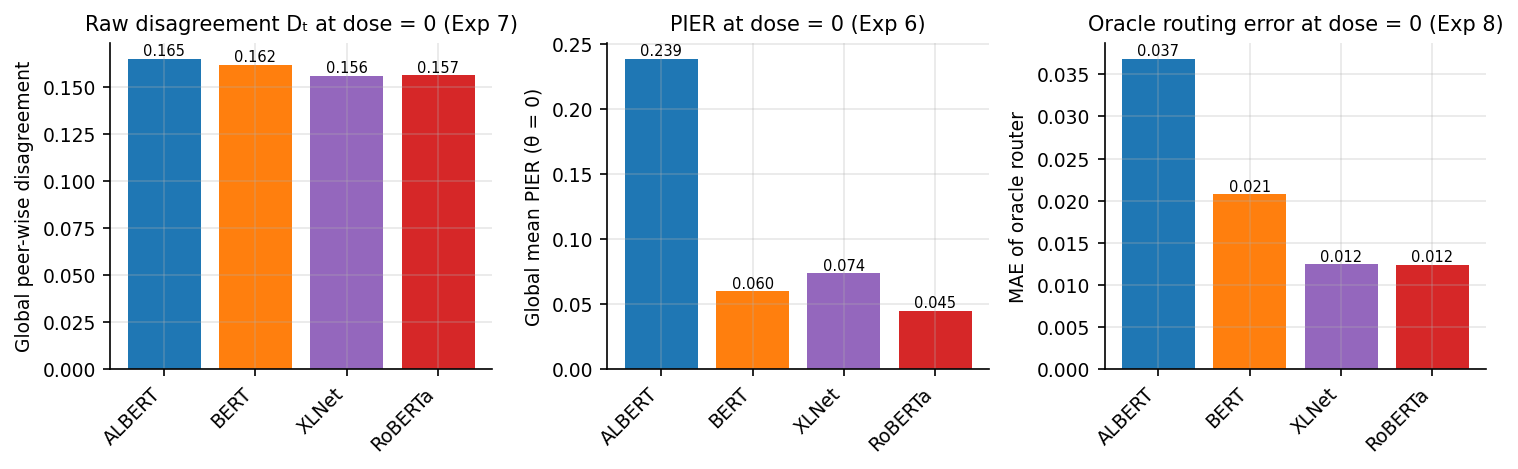

In [5]:
def plot_three_bar_metrics_row(summary_df: pd.DataFrame):
    """
    Plot three aligned bar charts (one row) for:
        - PIER_Dose0 (Exp 6)
        - GlobalDisagreement_D (Exp 7)
        - MAE_OracleRouter (Exp 8)

    Model order is fixed as:
        ["ALBERT", "BERT", "XLNet", "RoBERTa"]

    Bar colors are aligned with the line-plot legend:
        ALBERT     -> tab:blue
        BERT       -> tab:orange
        DistilBERT -> tab:green
        RoBERTa    -> tab:red
        XLNet      -> tab:purple
    """

    # Desired display order (DistilBERT is not included in this panel)
    desired_order = ["ALBERT", "BERT", "XLNet", "RoBERTa"]

    # Color map consistent with your line plots
    color_map = {
        "ALBERT": "tab:blue",
        "BERT": "tab:orange",
        # "DistilBERT": "tab:green",  # Not used here
        "RoBERTa": "tab:red",
        "XLNet": "tab:purple",
    }

    # Filter + reorder rows
    df = summary_df.copy()
    df = df[df["TargetModel"].isin(desired_order)]
    df["Order"] = df["TargetModel"].map({m: i for i, m in enumerate(desired_order)})
    df = df.sort_values("Order")
    df = df.drop(columns=["Order"])

    models = df["TargetModel"].tolist()
    x = np.arange(len(models))

    metrics = [
        ("GlobalDisagreement_D", "Raw disagreement Dₜ at dose = 0 (Exp 7)", "Global peer-wise disagreement"),
        ("PIER_Dose0", "PIER at dose = 0 (Exp 6)", "Global mean PIER (θ = 0)"),
        ("MAE_OracleRouter", "Oracle routing error at dose = 0 (Exp 8)", "MAE of oracle router"),
    ]

    fig, axes = plt.subplots(1, 3, figsize=(10, 3.2), sharey=False)

    for ax, (col, title, ylabel) in zip(axes, metrics):
        vals = df[col].values
        bar_colors = [color_map[m] for m in models]

        ax.bar(x, vals, color=bar_colors)
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=45, ha="right")

        ax.set_title(title, fontsize=10)
        ax.set_ylabel(ylabel)

        # Value labels on bars
        for xi, v in zip(x, vals):
            ax.text(
                xi,
                v,
                f"{v:.3f}",
                ha="center",
                va="bottom",
                fontsize=7,
            )

        ax.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()


# Draw the figure
plot_three_bar_metrics_row(summary)


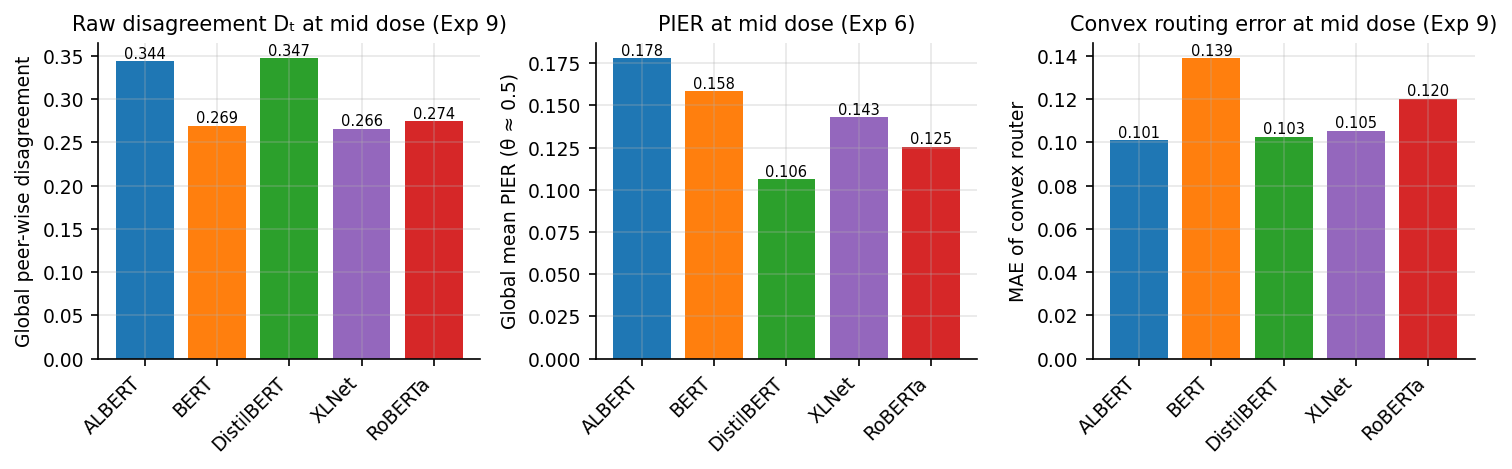

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (4.0, 3.0)
plt.rcParams["figure.dpi"] = 150
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.3
plt.rcParams["font.size"] = 9
plt.rcParams["legend.frameon"] = False

# ----------------------------------------------------------
# 1. Load Exp 6 (PIER) and revised Exp 9 (convex routing)
# ----------------------------------------------------------
tables_dir = os.path.join("..", "results", "tables")
exp6_path = os.path.join(tables_dir, "exp6_bert_multicontext_pier.csv")
exp9_path = os.path.join(tables_dir, "exp9_routing_sanity_dose05_convex.csv")

exp6_df = pd.read_csv(exp6_path)
exp9_df = pd.read_csv(exp9_path)

# ----------------------------------------------------------
# 2. Global PIER at mid dose (closest to 0.5)
# ----------------------------------------------------------
def compute_pier_at_dose(exp6_df: pd.DataFrame, dose_target: float) -> pd.DataFrame:
    doses = exp6_df["Dose"].unique()
    closest_dose = float(doses[np.argmin(np.abs(doses - dose_target))])
    sub = exp6_df[np.isclose(exp6_df["Dose"], closest_dose)].copy()
    pier_global = (
        sub.groupby("TargetModel")["MeanPIER"]
        .mean()
        .reset_index()
        .rename(columns={"MeanPIER": "PIER_DoseMid"})
    )
    pier_global["Dose_Exp6"] = closest_dose
    return pier_global

pier_mid = compute_pier_at_dose(exp6_df, dose_target=0.5)

# ----------------------------------------------------------
# 3. Merge into a single summary table
# ----------------------------------------------------------
summary_mid = exp9_df.merge(pier_mid, on="TargetModel", how="left")

summary_mid = summary_mid[
    [
        "TargetModel",
        "GlobalDisagreement_D",
        "MAE_SinglePeer",
        "BestPeerName",
        "MAE_OracleRouter",
        "MAE_ConvexRouter",
        "PIER_DoseMid",
        "Dose",
        "NumFitSamples",
        "NumEvalSamples",
    ]
]

summary_mid

# ----------------------------------------------------------
# 4. Bar plots (one row, 4 panels) for mid-dose metrics
# ----------------------------------------------------------
def plot_four_bar_metrics_row_mid(summary_df: pd.DataFrame):
    desired_order = ["ALBERT", "BERT", "DistilBERT", "XLNet", "RoBERTa"]
    color_map = {
        "ALBERT": "tab:blue", # Not used here
        "BERT": "tab:orange",
        "DistilBERT": "tab:green",
        "RoBERTa": "tab:red",
        "XLNet": "tab:purple",
    }

    df = summary_df.copy()
    df = df[df["TargetModel"].isin(desired_order)]
    df["Order"] = df["TargetModel"].map({m: i for i, m in enumerate(desired_order)})
    df = df.sort_values("Order").drop(columns=["Order"])

    models = df["TargetModel"].tolist()
    x = np.arange(len(models))

    metrics = [
        ("GlobalDisagreement_D", "Raw disagreement Dₜ at mid dose (Exp 9)", "Global peer-wise disagreement"),
        ("PIER_DoseMid", "PIER at mid dose (Exp 6)", "Global mean PIER (θ ≈ 0.5)"),
        # ("MAE_OracleRouter", "Oracle routing error at mid dose (Exp 9)", "MAE of oracle router"),
        ("MAE_ConvexRouter", "Convex routing error at mid dose (Exp 9)", "MAE of convex router"),
    ]

    fig, axes = plt.subplots(1, 3, figsize=(10, 3.2), sharey=False)

    for ax, (col, title, ylabel) in zip(axes, metrics):
        vals = df[col].values
        bar_colors = [color_map[m] for m in models]

        ax.bar(x, vals, color=bar_colors)
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=45, ha="right")

        ax.set_title(title, fontsize=10)
        ax.set_ylabel(ylabel)

        for xi, v in zip(x, vals):
            ax.text(
                xi,
                v,
                f"{v:.3f}",
                ha="center",
                va="bottom",
                fontsize=7,
            )

        ax.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()


plot_four_bar_metrics_row_mid(summary_mid)
